**Background:**

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

**Data Description:**

Page flipping video from smart phones and labelled  as flipping and not flipping. 

Short videos  labelled them  flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

**Importing the Data**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images/images/training/notflip/0036_000000026.jpg
/kaggle/input/images/images/training/notflip/0044_000000017.jpg
/kaggle/input/images/images/training/notflip/0004_000000024.jpg
/kaggle/input/images/images/training/notflip/0035_000000029.jpg
/kaggle/input/images/images/training/notflip/0041_000000005.jpg
/kaggle/input/images/images/training/notflip/0032_000000024.jpg
/kaggle/input/images/images/training/notflip/0005_000000004.jpg
/kaggle/input/images/images/training/notflip/0045_000000001.jpg
/kaggle/input/images/images/training/notflip/0026_000000017.jpg
/kaggle/input/images/images/training/notflip/0057_000000025.jpg
/kaggle/input/images/images/training/notflip/0035_000000031.jpg
/kaggle/input/images/images/training/notflip/0033_000000013.jpg
/kaggle/input/images/images/training/notflip/0058_000000023.jpg
/kaggle/input/images/images/training/notflip/0041_000000031.jpg
/kaggle/input/images/images/training/notflip/0005_000000007.jpg
/kaggle/input/images/images/training/not

In [2]:
#import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

**Deleting corrupted images:**

In [3]:
import os

num_skipped = 0
for folder_name in ("flip", "notflip"):
    folder_path = os.path.join("/kaggle/input/images/images/testing/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
import os

num_skipped = 0
for folder_name in ("flip", "notflip"):
    folder_path = os.path.join("/kaggle/input/images/images/training/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [5]:
#Setting the data training parameters
image_size = (180,180)
batch_size = 12

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/images/images/training",
    validation_split=0.20,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)


Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Using 478 files for validation.


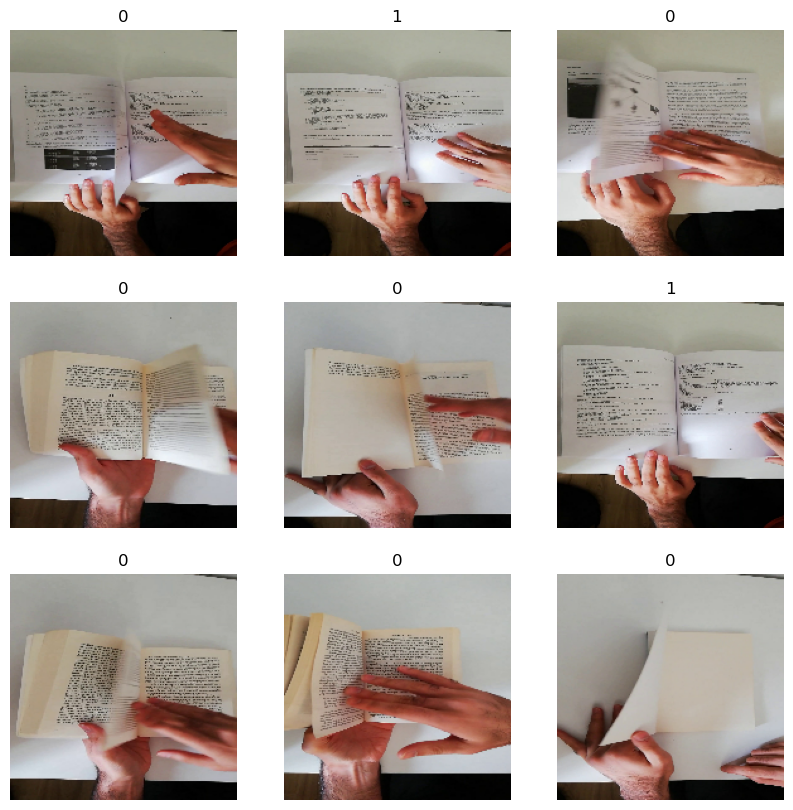

In [6]:
#Plotting sample of flipping images from the training data 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
        


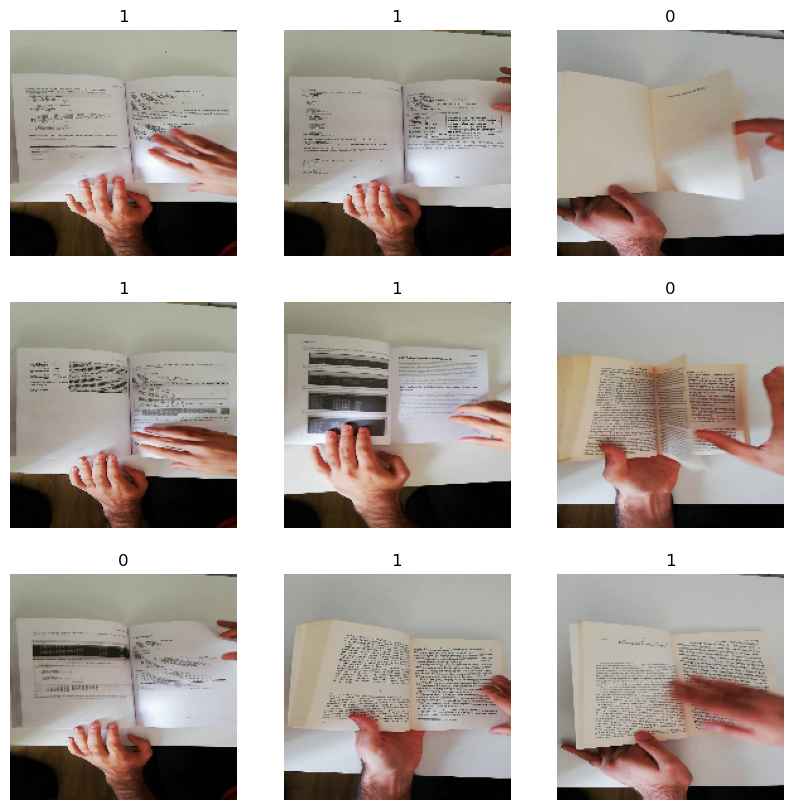

In [7]:
#Plotting sample of images from the validitng data 
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**Creating data augmentation to enhance the model**

In [8]:
data_augmentation = keras.Sequential(
     [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.3),
     ]
)

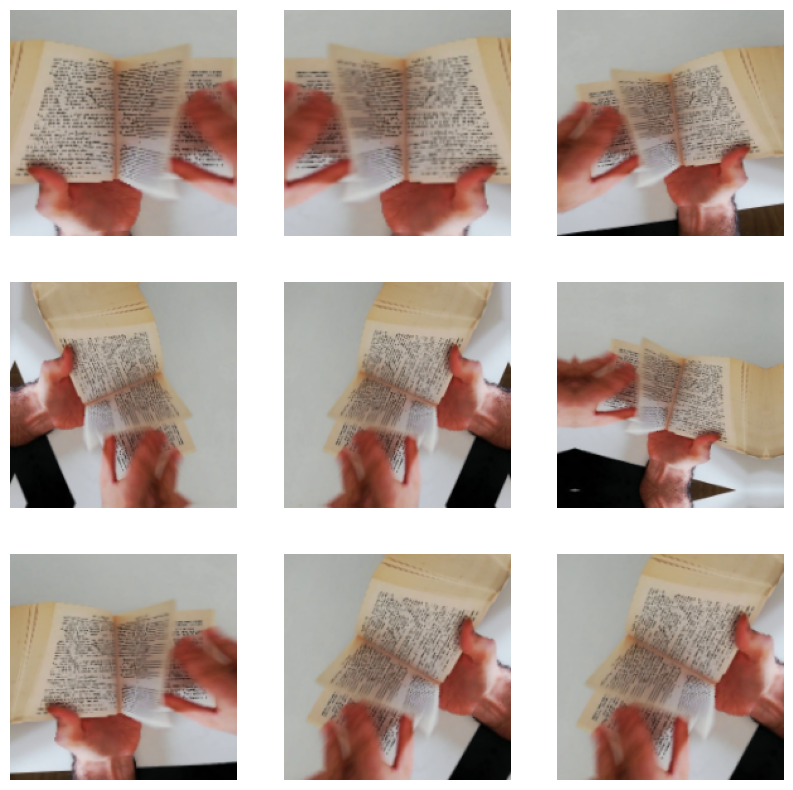

In [9]:
#plot random image samples after data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
   for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
#making the agumented dataset as the training dataset 
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [11]:
#Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
#Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

**Creating keras CNN training model:**

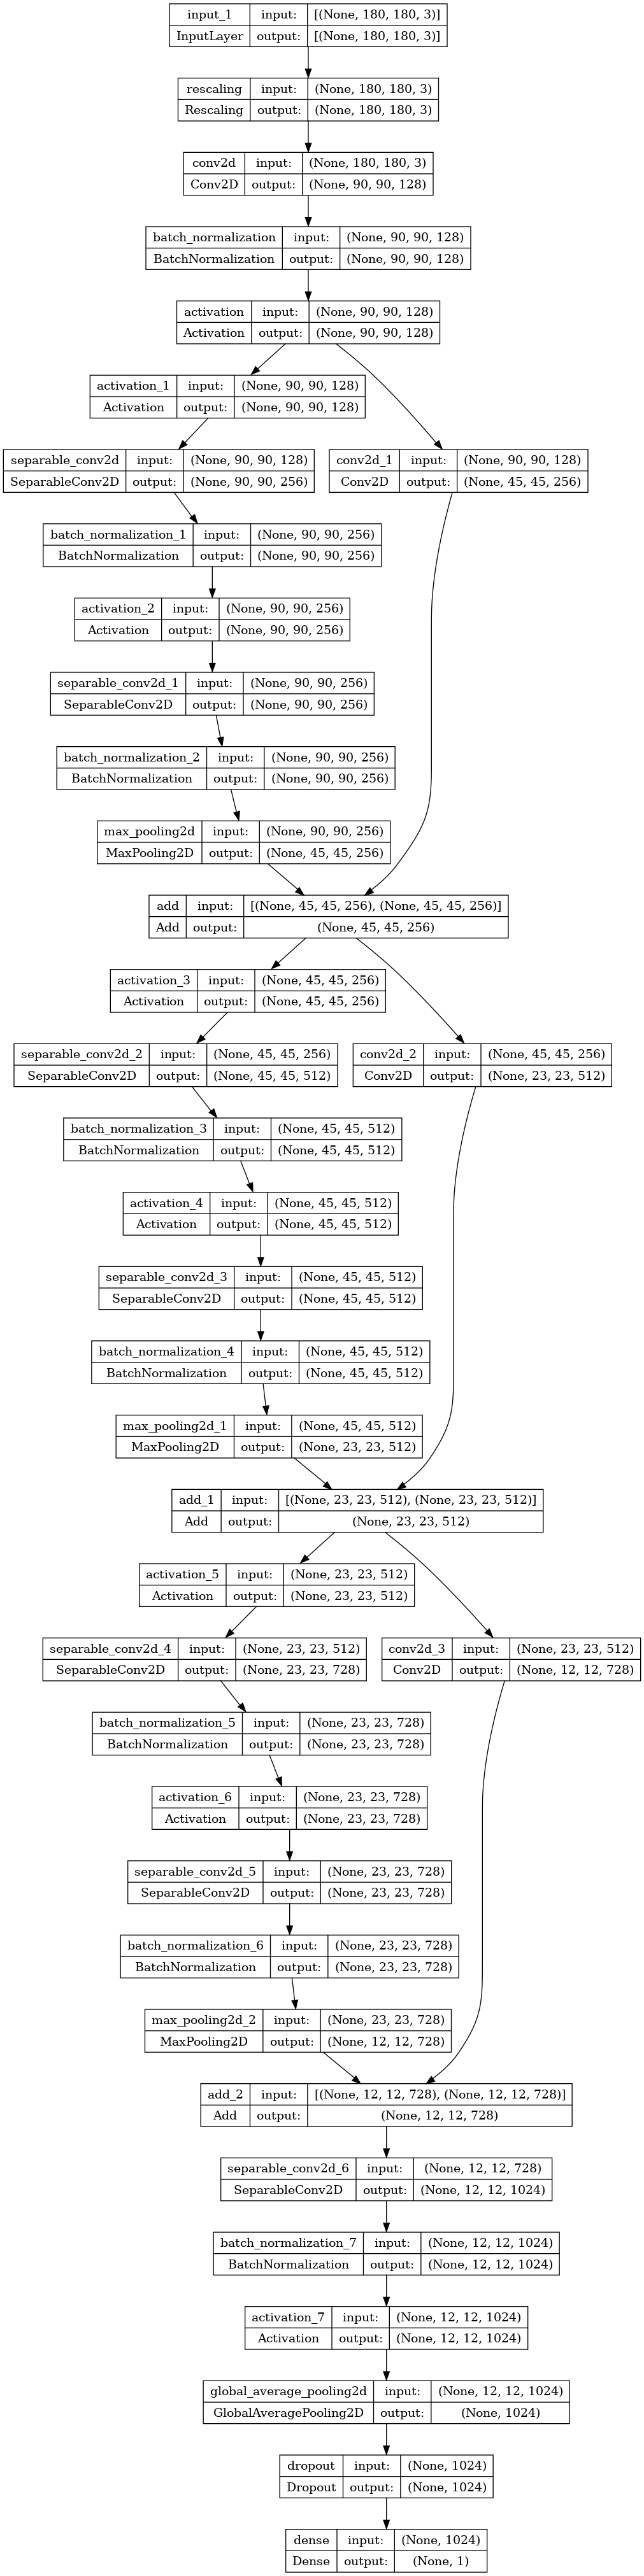

In [12]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

    # Increase model complexity
    model.add(layers.Conv2D(1024, 3, padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
#Applying the CNN model on the training data

epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Use early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=val_ds,
)

model.save('my.model')

Epoch 1/20
160/160 [==============================] - 56s 216ms/step - loss: 0.6437 - accuracy: 0.6202 - val_loss: 0.6923 - val_accuracy: 0.5251
Epoch 2/20
160/160 [==============================] - 34s 205ms/step - loss: 0.4897 - accuracy: 0.7618 - val_loss: 0.6942 - val_accuracy: 0.4749
Epoch 3/20
160/160 [==============================] - 33s 201ms/step - loss: 0.4242 - accuracy: 0.8083 - val_loss: 0.7110 - val_accuracy: 0.4749
Epoch 4/20
160/160 [==============================] - 33s 203ms/step - loss: 0.3932 - accuracy: 0.8213 - val_loss: 0.5621 - val_accuracy: 0.6778
Epoch 5/20
160/160 [==============================] - 36s 218ms/step - loss: 0.3826 - accuracy: 0.8302 - val_loss: 0.3638 - val_accuracy: 0.8347
Epoch 6/20
160/160 [==============================] - 34s 208ms/step - loss: 0.3727 - accuracy: 0.8323 - val_loss: 0.3552 - val_accuracy: 0.8368
Epoch 7/20
160/160 [==============================] - 33s 202ms/step - loss: 0.3721 - accuracy: 0.8302 - val_loss: 0.3245 - val_ac

1/1 [==============================] - 1s 684ms/step
This image is 95.90% flip and 4.10% notflip.
0.040965836495161057


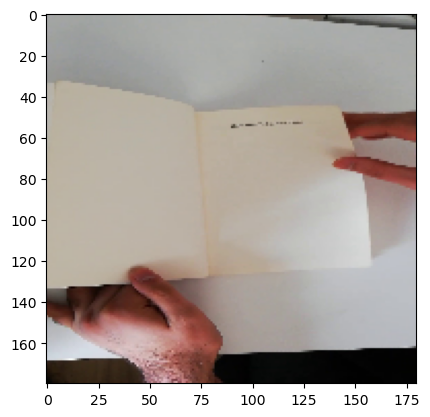

In [14]:
#Testing the. model on random image from the flip testing data

import random

flip_dir = "/kaggle/input/images/images/testing/flip"
flip_files = os.listdir(flip_dir)
flip_file = os.path.join(flip_dir, random.choice(flip_files))

img = keras.utils.load_img(flip_file, target_size=image_size)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% flip and {100 * score:.2f}% notflip.")
print(score)
plt.imshow(img)

1/1 [==============================] - 0s 36ms/step
This image is 1.97% flip and 98.03% notflip.
0.9802806973457336


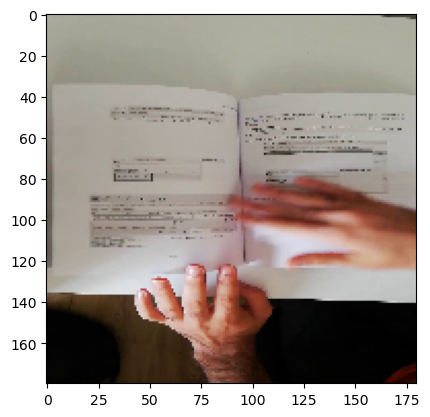

In [15]:
#Testing the. model on random image from the not flip testing data


notflip_dir = "/kaggle/input/images/images/testing/notflip"
notflip_files = os.listdir(notflip_dir)
notflip_file = os.path.join(notflip_dir, random.choice(notflip_files))

img = keras.utils.load_img(notflip_file, target_size=image_size)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% flip and {100 * score:.2f}% notflip.")
print(score)
plt.imshow(img)

**Comparining the accuracy of the modle on the validation data and the training data:**

40/40 [==============================] - 4s 100ms/step - loss: 0.2250 - accuracy: 0.8954
Validation loss: 0.2250
Validation accuracy: 0.8954
160/160 [==============================] - 24s 146ms/step - loss: 0.2250 - accuracy: 0.9007
Training loss: 0.2250
Training accuracy: 0.9007


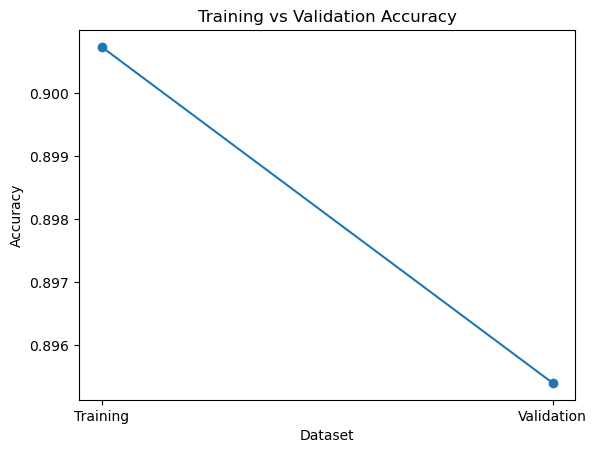

In [16]:
import matplotlib.pyplot as plt

# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation loss: {val_loss:.4f}") 
print(f"Validation accuracy: {val_acc:.4f}")

# Evaluate on training data
train_loss, train_acc = model.evaluate(train_ds)
print(f"Training loss: {train_loss:.4f}")
print(f"Training accuracy: {train_acc:.4f}") 

# Plot accuracy values
plt.plot([1,2], [train_acc, val_acc], marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.xticks([1,2], ['Training', 'Validation'])
plt.show()

**Evaluation the model by testing the F1 score:**

In [17]:
from sklearn.metrics import f1_score


# Load the trained model
model = tf.keras.models.load_model("my.model")

# Get the ground-truth labels and predicted labels for the test dataset
y_true = []
y_pred = []
for images, labels in train_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images).argmax(axis=1))

# Compute the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"F1 score: {f1:.4f}")

1/1 [==============================] - 0s 23ms/step
F1 score: 0.3206
